In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Tue Jan 16 12:16:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8              N/A / ERR! |   1974MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
num_heads = 12
equation_name = "FP"

np.random.seed(42)

# create the A matrix associated with the ODE
def get_A():
    return torch.tensor([[0.0]], device=dev).double() 
A_list = [get_A() for i in range(num_heads)]

IC_list = list(torch.logspace(start=-4, end=0, steps=num_heads, device=dev).unsqueeze(dim=1))

# training force (random or not)
def random_force(force1_bound=[0, 1]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    return torch.tensor(force1, device=dev)
force_list = [random_force() for i in range(num_heads)]

In [5]:
x_range = [0, 2]
activation = "tanh"
hid_lay = list(np.array([124, 124, 132]) * 1)
num_equations = 1
iterations = 5000

In [6]:
sample_size = 200
lr = 0.00005
decay = True
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr,
                                                           A_list=A_list, v_list=IC_list, force=force_list,
                                                           hid_lay=hid_lay, activation=activation,
                                                           num_equations=num_equations, num_heads=num_heads,
                                                           sample_size = sample_size, decay=decay, dev=dev, verbose=verbose,
                                                           save=False)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 0/5000 [00:00<?, ?it/s]

Iterations 0: loss = 0.5413293689054608


 10%|█         | 502/5000 [00:27<04:09, 18.05it/s]

Iterations 500: loss = 0.006588881894274486


 20%|██        | 1005/5000 [00:51<03:16, 20.32it/s]

Iterations 1000: loss = 0.000865615111479535


 30%|███       | 1502/5000 [01:15<02:55, 19.98it/s]

Iterations 1500: loss = 0.0004148249738814857


 40%|████      | 2004/5000 [01:40<02:27, 20.30it/s]

Iterations 2000: loss = 0.0002920690023219845


 50%|█████     | 2504/5000 [02:06<02:03, 20.29it/s]

Iterations 2500: loss = 0.00020497112184965499


 60%|██████    | 3002/5000 [02:31<01:44, 19.19it/s]

Iterations 3000: loss = 0.00010770411713582373


 70%|███████   | 3504/5000 [02:57<01:11, 21.01it/s]

Iterations 3500: loss = 7.080991964549607e-05


 80%|████████  | 4002/5000 [03:21<00:49, 20.24it/s]

Iterations 4000: loss = 4.718620669006016e-05


 90%|█████████ | 4503/5000 [03:46<00:24, 20.55it/s]

Iterations 4500: loss = 1.752792055885838e-05


100%|██████████| 5000/5000 [04:11<00:00, 19.91it/s]

Model Training Complete in 251.263 seconds


In [7]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0] * y[0]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v, args=(A, force), t_eval=x.squeeze(), method="Radau").y)

C:\Users\Emilien\AppData\Local\Temp\ipykernel_16716\2287715937.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([force[0].detach().item() - A[0] * y[0]])


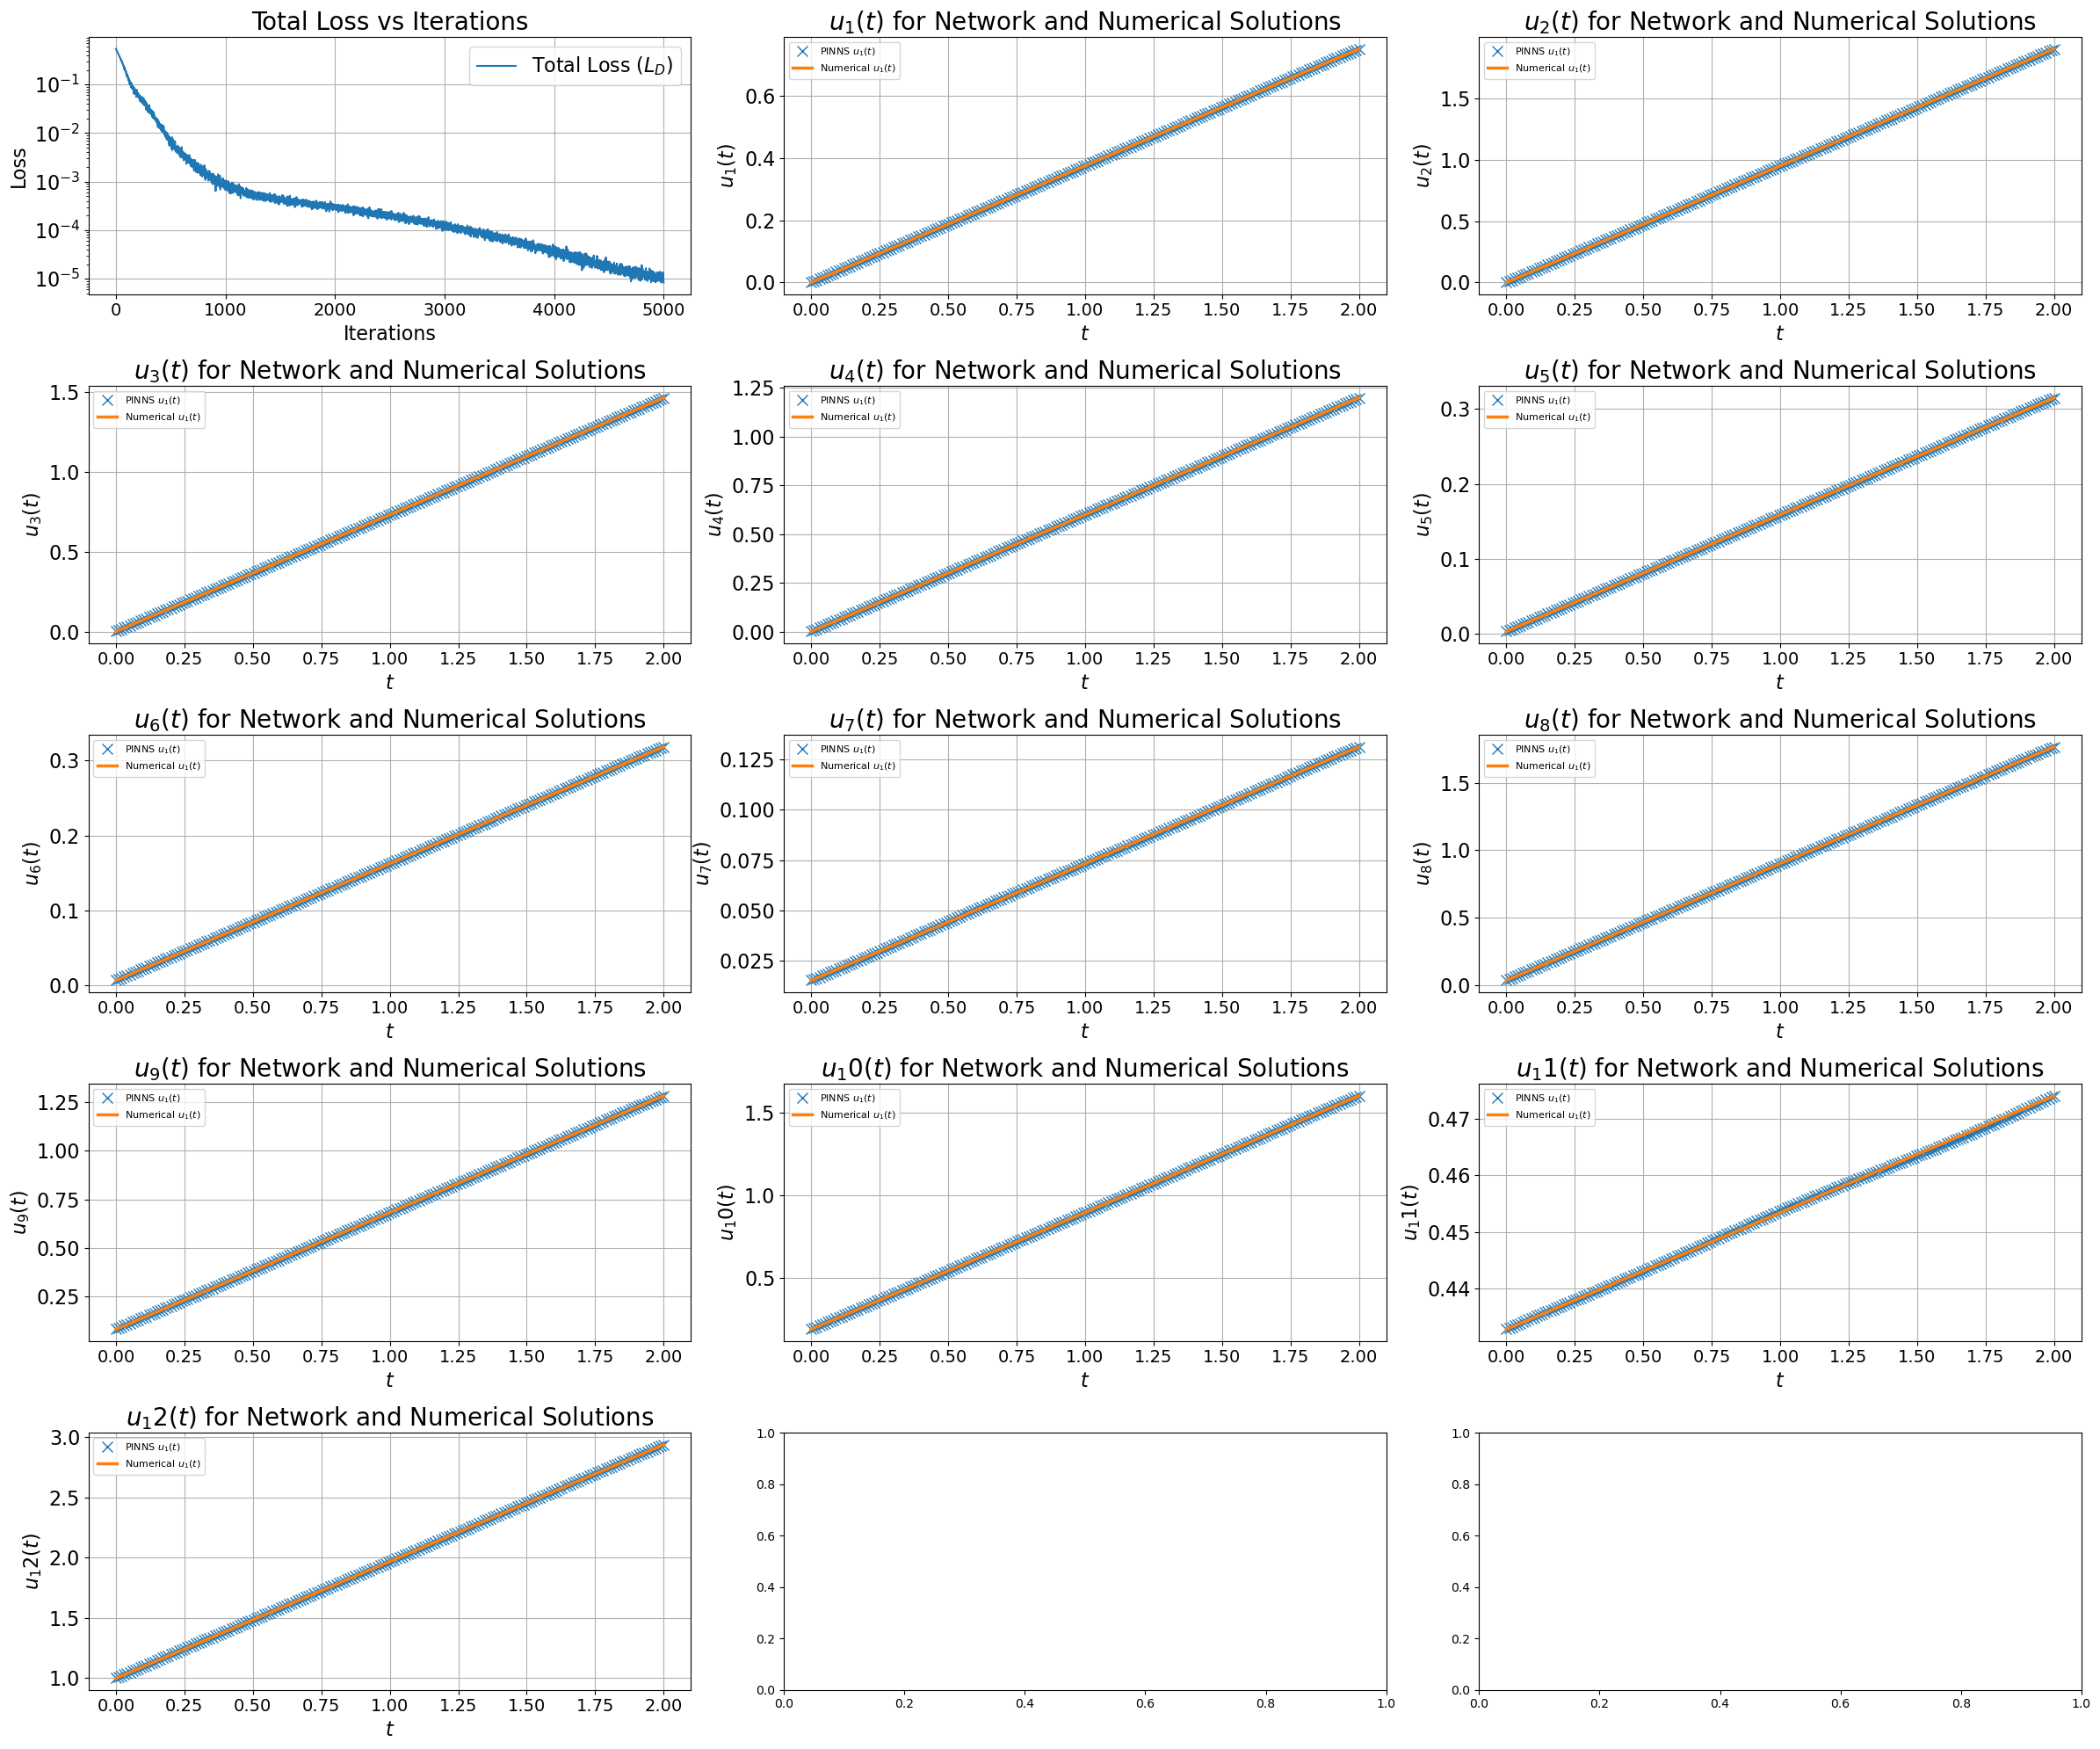

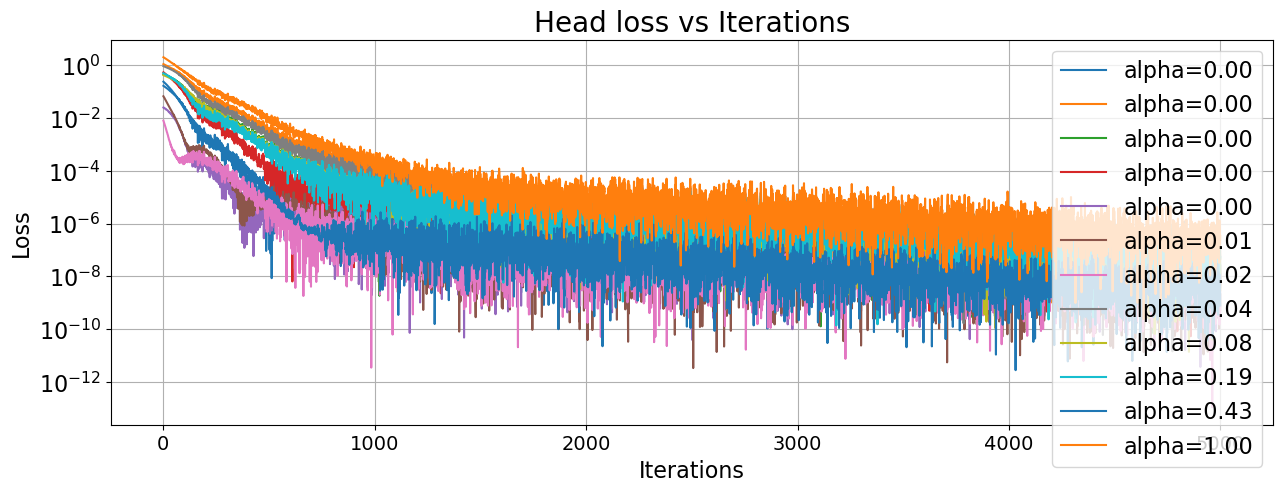

In [8]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)
plot_head_loss(loss_hist["head"], [ic.item() for ic in IC_list])

In [9]:
model_name = "inference"
save_model(trained_model, formatted_datetime_int, equation_name, model_name,
           x_range, iterations, hid_lay, num_equations, num_heads, A_list,
           IC_list, force_list, [None], loss_hist)

D:\Emilien\Documents\Cours\Master_Thesis\Harvard_Master_Thesis\model_history/FP/history_inference_1161221.json
